# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import udkm1Dsim as ud
u = ud.u  # import the pint unit registry from udkm1Dsim

In [2]:
%matplotlib widget
u.setup_matplotlib()  # use matplotlib with pint units
plt.style.use("C:/Users/lunin/mbi/matplotlib-mbi-style/mbi_paper.mplstyle")

# Structure

In [45]:
# #not required
# FeGd = ud.AtomMixed('FeGd', id='FeGd', name='FeGd', mag_amplitude=1, mag_phi=0*u.deg, mag_gamma=90*u.deg)
# FeGd.add_atom(Fe, .5)
# FeGd.add_atom(Gd, .5)

In [3]:
form_folder = 'combined_coefs/'

In [4]:
#all required atoms
Fe = ud.Atom('Fe', mag_amplitude=1, mag_phi=0*u.deg, mag_gamma=90*u.deg,
                   atomic_form_factor_path=form_folder + 'fe_comb.nff', magnetic_form_factor_path = form_folder + 'fe_comb.mf')
Gd = ud.Atom('Gd', mag_amplitude=1, mag_phi=0*u.deg, mag_gamma=90*u.deg,
                   atomic_form_factor_path=form_folder + 'gd_comb.nff', magnetic_form_factor_path = form_folder + 'gd_comb.mf')
Ta = ud.Atom('Ta', atomic_form_factor_source = 'henke')
Si = ud.Atom('Si', atomic_form_factor_source = 'henke')
N = ud.Atom('N', atomic_form_factor_source = 'henke')
print(Gd.get_atomic_form_factor(707.717))
print(Gd.get_magnetic_form_factor(707.717))

print(Fe.get_atomic_form_factor(1184.79))
print(Fe.get_magnetic_form_factor(1184.79))

(31.1698-11.2613j)
0j
(24.326647049525818-9.44673177028451j)
(-0.003979200460561696+0j)


In [5]:
#source: wiki 
density_SiN = 3.44*u.g/u.cm**3
SiN = ud.AtomMixed('SiN', id='SiN', name='Silicon-Nitride membrane')
SiN.add_atom(Si, 3/7)
SiN.add_atom(N, 4/7)

ground_layer = ud.AmorphousLayer('SiN', 'SiN base', 100*u.nm, density_SiN, atom=SiN)

In [6]:
density_Fe = 7874*u.kg/u.m**3
prop_Fe = {}
prop_Fe['heat_capacity'] = 449*u.J/u.kg/u.K
prop_Fe['therm_cond'] = 80*u.W/(u.m *u.K)

density_Gd = 7886*u.kg/u.m**3
prop_Gd = {}
prop_Gd['heat_capacity'] = 300*u.J/u.kg/u.K
prop_Gd['therm_cond'] = 11*u.W/(u.m *u.K)

layer_Fe = ud.AmorphousLayer('Fe', 'Fe amorphous', 0.41*u.nm, density_Fe, atom=Fe)
layer_Gd = ud.AmorphousLayer('Gd', 'Gd amorphous', 0.45*u.nm, density_Gd, atom=Gd)

In [7]:
# source: wikipedia and Lisa
density_Ta = 16.65e3*u.kg/u.m**3 

layer_Ta_finish = ud.AmorphousLayer('Ta', 'Ta amorphous', 2*u.nm, density_Ta, atom=Ta)

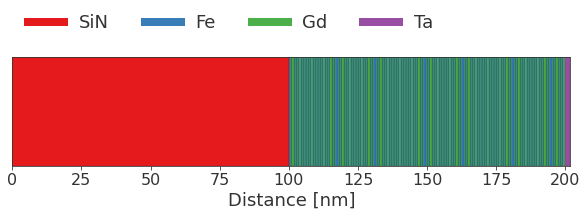

In [8]:
%matplotlib inline

# create a sub-structure
DL = ud.Structure('Fe/Gd layer')
DL.add_sub_structure(layer_Fe, 1)
DL.add_sub_structure(layer_Gd, 1)



S = ud.Structure('Fe/Pt multilayer')

S.add_sub_structure(ground_layer, 1)
S.add_sub_structure(DL, 116)
S.add_sub_structure(layer_Ta_finish, 1)

#plt.ioff()
S.visualize(fig_size = (10, 2))
#plt.ion()

## Magnetization

In [9]:
dyn_mag = ud.XrayDynMag(S, True)
dyn_mag.disp_messages = True
dyn_mag.save_data = False
dyn_mag.set_polarization(1, 0)

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: circ +
analyzer polarizations set to: unpolarized


In [10]:
dyn_mag.energy = np.linspace(50,100,1000)*u.eV  # set two photon energies
# dyn_mag.energy = np.r_[50, 70]*u.eV  # set two photon energies
dyn_mag.theta = 90*u.deg  # angle of incidence
# dyn_mag.qz = np.r_[0.01:5:0.01]/u.nm  # qz range

In [11]:
R_hom, R_hom_phi, T_hom, T_hom_phi = dyn_mag.homogeneous_reflectivity()  # this is the actual calculation

print(R_hom**2 + T_hom**2)
print(R_hom_phi ,T_hom_phi)

Calculating _homogeneous_reflectivity_ ...
Elapsed time for _homogeneous_reflectivity_: 0.164141 s
[[2.22288025e-05]
 [2.23208127e-05]
 [2.24299752e-05]
 [2.25553207e-05]
 [2.26958192e-05]
 [2.28503788e-05]
 [2.30178460e-05]
 [2.31970059e-05]
 [2.33865833e-05]
 [2.35852443e-05]
 [2.37915987e-05]
 [2.40042035e-05]
 [2.42203011e-05]
 [2.44392773e-05]
 [2.46597265e-05]
 [2.48800150e-05]
 [2.50984868e-05]
 [2.53134723e-05]
 [2.55232971e-05]
 [2.57262921e-05]
 [2.59208039e-05]
 [2.61052052e-05]
 [2.62779058e-05]
 [2.64373640e-05]
 [2.65820971e-05]
 [2.67106926e-05]
 [2.68218190e-05]
 [2.69142354e-05]
 [2.69846005e-05]
 [2.70317949e-05]
 [2.70568338e-05]
 [2.70589329e-05]
 [2.70374417e-05]
 [2.69918482e-05]
 [2.69217821e-05]
 [2.68270167e-05]
 [2.67074696e-05]
 [2.65632021e-05]
 [2.63944170e-05]
 [2.62014554e-05]
 [2.59847919e-05]
 [2.57450295e-05]
 [2.54828922e-05]
 [2.51992175e-05]
 [2.48949478e-05]
 [2.45544121e-05]
 [2.41936496e-05]
 [2.38153924e-05]
 [2.34210083e-05]
 [2.30119202e-05]
 

 [1.18800591e-05]] [[0.0008203 ]
 [0.00082635]
 [0.00083243]
 [0.00083854]
 [0.00084467]
 [0.00085084]
 [0.00085704]
 [0.00086326]
 [0.00086952]
 [0.0008758 ]
 [0.00088212]
 [0.00088846]
 [0.00089451]
 [0.00090052]
 [0.00090657]
 [0.00091263]
 [0.00091873]
 [0.00092485]
 [0.00093099]
 [0.00093716]
 [0.00094336]
 [0.00094959]
 [0.00095584]
 [0.00096212]
 [0.00096842]
 [0.00097476]
 [0.00098112]
 [0.0009875 ]
 [0.00099411]
 [0.00100092]
 [0.00100776]
 [0.00101463]
 [0.00102154]
 [0.00102849]
 [0.00103546]
 [0.00104248]
 [0.00104952]
 [0.0010566 ]
 [0.00106372]
 [0.00107087]
 [0.00107805]
 [0.00108527]
 [0.00109253]
 [0.00109982]
 [0.00110714]
 [0.00111462]
 [0.00112215]
 [0.00112972]
 [0.00113732]
 [0.00114496]
 [0.00115264]
 [0.00116035]
 [0.0011681 ]
 [0.00117589]
 [0.00118372]
 [0.00119159]
 [0.00119949]
 [0.00120744]
 [0.00121542]
 [0.00122344]
 [0.00123149]
 [0.00123937]
 [0.00124311]
 [0.00124685]
 [0.00125059]
 [0.00125435]
 [0.00125811]
 [0.00126187]
 [0.00126564]
 [0.00126942]
 

IndexError: index 0 is out of bounds for axis 0 with size 0

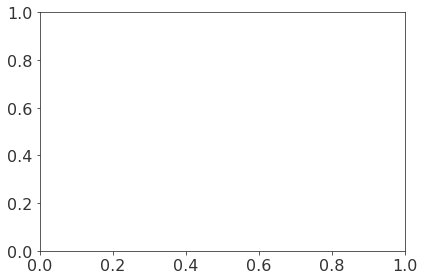

In [53]:
fig, ax = plt.subplots(tight_layout = True)
# ax.semilogy(dyn_mag.energy, T_hom, label=r'$T_+$')
# ax.semilogy(dyn_mag.energy, T_hom_phi, label=r'$T_-$')
ax.plot(dyn_mag.energy, T_hom_phi - T_hom, label=r'$T_-$ - $T_+$')

# ax.semilogy(dyn_mag.qz[0, :], R_hom[0, :], label='{}'.format(dyn_mag.energy[0]))
# ax.semilogy(dyn_mag.qz[1, :], R_hom[1, :], label='{}'.format(dyn_mag.energy[1]))
ax.set_ylabel('Transmission')
ax.set_xlabel(r'energy (eV)')
ax.legend()

In [12]:
%matplotlib widget
e,_, beta = np.loadtxt(form_folder + 'gd_comb.nff', unpack=True)
e,_,delta_beta = np.loadtxt(form_folder + 'gd_comb.mf', unpack=True)
print('Max resonant energy Gd: %.2f' % e[np.argmax(np.abs(delta_beta))])

plt.plot(e,beta+delta_beta)
plt.plot(e, beta-delta_beta)
plt.xlabel('energy / eV')
plt.ylabel('formfaktor beta, f\'\'')
print('Max resonant energy Fe: %.2f' % e[np.argmax(np.abs(delta_beta))])

Max resonant energy Gd: 1184.79


ValueError: operands could not be broadcast together with shapes (1057,) (1006,) 

## Determine figure of merit

### Fe/Gd multilayers

In [28]:
T = np.zeros(200)
P = np.zeros(200)
TP = np.zeros(200)

for i in range(1, 201):
    
    S = ud.Structure('Gd/Fe multilayer')
    S.add_sub_structure(ground_layer, 1)
    S.add_sub_structure(DL, i)
    S.add_sub_structure(layer_Ta_finish, 1)
    
    dyn_mag = ud.XrayDynMag(S, True)
    dyn_mag.disp_messages = False
    dyn_mag.save_data = False
    dyn_mag.set_polarization(1, 0)
    dyn_mag.energy = [706.97]*u.eV  # set two photon energies
    dyn_mag.theta = 90*u.deg  # angle of incidence
    _, _, T_hom, T_hom_phi = dyn_mag.homogeneous_reflectivity()  # this is the actual calculation
    T[i-1] = (T_hom + T_hom_phi) / 2
    P[i-1] = (T_hom - T_hom_phi) / (T_hom + T_hom_phi)
    TP[i-1] = T[i-1] * P[i-1]**2

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
ana

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
ana

In [30]:
layer_nr = range(1,201)

np.savetxt('Fe_706_97_0_200_layers.csv', np.column_stack((layer_nr, T, P)), header="number of Gd/Fe layers, transmission, polarisation", delimiter=",")

Fe abs(TP^2): 3.533e-02


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
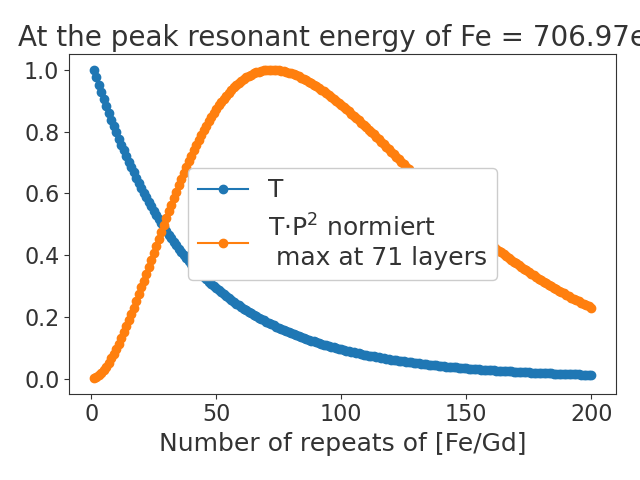

In [29]:
fig, ax = plt.subplots(tight_layout = True)
ax.plot(np.arange(1, 201, 1), T/np.max(T), 'o-', label = 'T')
# ax.plot(np.arange(0, 116, 1), P, label = 'P')
ax.plot(np.arange(1, 201, 1), TP/np.max(TP), 'o-', label = 'T$\cdot$P$^2$ normiert\n max at %d layers' % np.argmax(TP))
ax.legend()
ax.set_title('At the peak resonant energy of Fe = 706.97eV')
ax.set_xlabel('Number of repeats of [Fe/Gd]')
print('Fe abs(TP^2): %.3e' % np.max(TP))

In [31]:
T = np.zeros(200)
P = np.zeros(200)
TP = np.zeros(200)

for i in range(1, 201):
    
    S = ud.Structure('Gd/Fe multilayer')
    S.add_sub_structure(ground_layer, 1)
    S.add_sub_structure(DL, i)
    S.add_sub_structure(layer_Ta_finish, 1)
    
    dyn_mag = ud.XrayDynMag(S, True)
    dyn_mag.disp_messages = False
    dyn_mag.save_data = False
    dyn_mag.set_polarization(1, 0)
    dyn_mag.energy = [1184.79]*u.eV  # set two photon energies
    dyn_mag.theta = 90*u.deg  # angle of incidence
    _, _, T_hom, T_hom_phi = dyn_mag.homogeneous_reflectivity()  # this is the actual calculation
    T[i-1] = (T_hom + T_hom_phi) / 2
    P[i-1] = (T_hom - T_hom_phi) / (T_hom + T_hom_phi)
    TP[i-1] = T[i-1] * P[i-1]**2

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
ana

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
ana

In [32]:
layer_nr = range(1,201)

np.savetxt('Gd_1184_79_0_200_layers.csv', np.column_stack((layer_nr, T, P)), header="number of Gd/Fe layers, transmission, polarisation",  delimiter=",")

Gd TP^2 7.841e-02


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
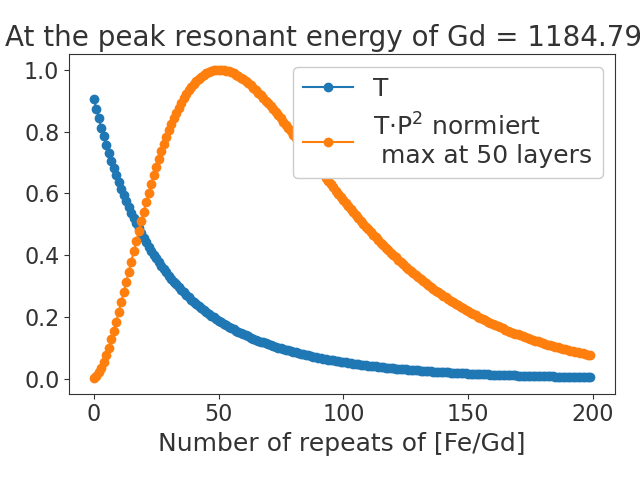

In [33]:
fig, ax = plt.subplots(tight_layout = True)
ax.plot(np.arange(0, 200, 1), T, 'o-', label = 'T')
# ax.plot(np.arange(0, 116, 1), P, label = 'P')
ax.plot(np.arange(0, 200, 1), TP/np.max(TP), 'o-', label = 'T$\cdot$P$^2$ normiert\n max at %d layers' % np.argmax(TP))
ax.legend()
ax.set_title('At the peak resonant energy of Gd = 1184.79eV')
ax.set_xlabel('Number of repeats of [Fe/Gd]')
print('Gd TP^2 %.3e' % np.max(TP))